In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from resnet1d import Res34SimSiam, Res34SimSiamSplitHeads
from dataset import Dataset_per_file, Dataset_whole, Dataset_ori
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
import os
import numpy as np
from tqdm import tqdm
import argparse
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import sys
import os
import matplotlib.pyplot as plt
from collections import OrderedDict


/labs/hulab/stark_conda/envs/base_pytorch37/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1)

In [5]:
simbad_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/data_simband_badquality_2400.npy')
staford_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/data_staford_badquality_2400.npy')
ucla_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/data_ucla_badquality_2400.npy')
ucla_goodqual = np.load('/labs/hulab/Robust_learning_TESTDATA/data_ucla_goodquality_2400.npy')

In [4]:
print(simbad_badqual.shape)
print(staford_badqual.shape)
print(ucla_badqual.shape)

(685, 2400)
(13934, 2400)
(76233, 2400)


# vital_sqi

In [6]:
from vital_sqi.sqi.standard_sqi import kurtosis_sqi, skewness_sqi, entropy_sqi, signal_to_noise_sqi

In [9]:
sqi_funcs = [kurtosis_sqi, skewness_sqi, entropy_sqi, signal_to_noise_sqi]

def calc_sqi(ppg):
    segs = np.split(ppg, 15)
    sqi = np.zeros((len(sqi_funcs)))
    for seg in segs:
        for idx in range(len(sqi_funcs)):
            sqi[idx] += sqi_funcs[idx](seg) 
    return sqi / 15

In [10]:
simband_badqual_ssqi = np.asarray([calc_sqi(ppg) for ppg in simbad_badqual])
staford_badqual_ssqi = np.asarray([calc_sqi(ppg) for ppg in staford_badqual])
ucla_badqual_ssqi = np.asarray([calc_sqi(ppg) for ppg in ucla_badqual])

/labs/hulab/stark_conda/envs/base_pytorch37/lib/python3.8/site-packages/vital_sqi/sqi/standard_sqi.py:70: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return kurtosis(x, axis, fisher, bias, nan_policy)
/labs/hulab/stark_conda/envs/base_pytorch37/lib/python3.8/site-packages/vital_sqi/sqi/standard_sqi.py:101: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis, bias, nan_policy)

KeyboardInterrupt



# SSQI

In [11]:
def calc_skewness(ppg):
    segs = np.split(ppg, 15)
    skewness = []
    for seg in segs:
        rst = np.sum(np.power((seg - np.mean(seg)) / np.std(seg), 3)) / seg.shape[0]
        skewness.append(rst)
    return np.asarray(skewness)

In [12]:
simband_badqual_ssqi = np.asarray([calc_skewness(ppg) for ppg in simbad_badqual])
staford_badqual_ssqi = np.asarray([calc_skewness(ppg) for ppg in staford_badqual])
ucla_badqual_ssqi = np.asarray([calc_skewness(ppg) for ppg in ucla_badqual])

In [18]:
print(np.mean(np.mean(np.abs(simband_badqual_ssqi), axis=1)), np.std(np.mean(np.abs(simband_badqual_ssqi), axis=1)))
print(np.mean(np.mean(np.abs(ucla_badqual_ssqi), axis=1)), np.std(np.mean(np.abs(ucla_badqual_ssqi), axis=1)))
print(np.mean(np.mean(np.abs(staford_badqual_ssqi), axis=1)), np.std(np.mean(np.abs(staford_badqual_ssqi), axis=1)))

0.36850023623896144 0.18243561442064848
0.33765840323631036 0.15312843911351115
0.5719448920771701 0.2355565517362637


In [21]:
print(np.sum(np.mean(np.abs(simband_badqual_ssqi), axis=1) > 0.4))
print(np.sum(np.mean(np.abs(ucla_badqual_ssqi), axis=1) > 0.4))
print(np.sum(np.mean(np.abs(staford_badqual_ssqi), axis=1) > 0.4))

249
20436
10904


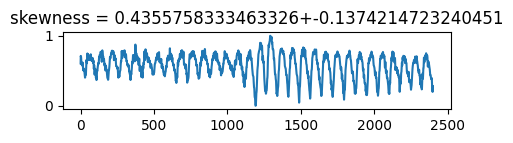

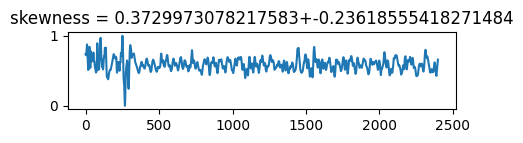

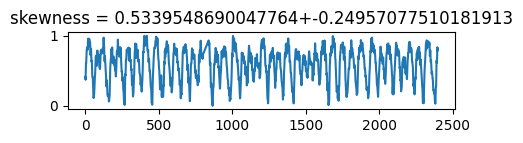

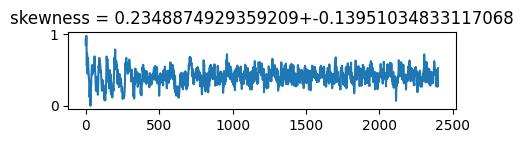

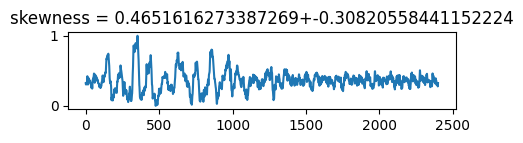

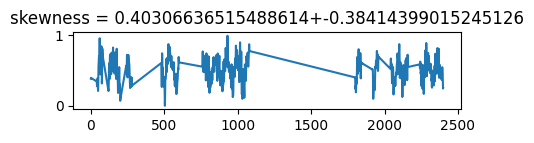

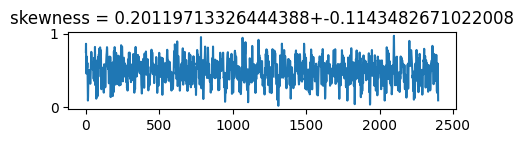

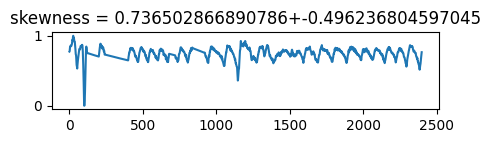

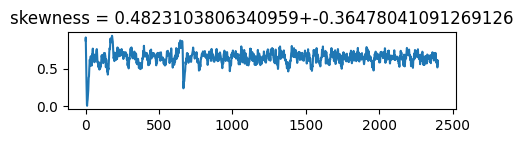

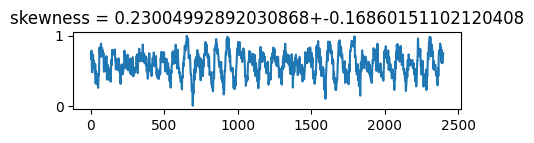

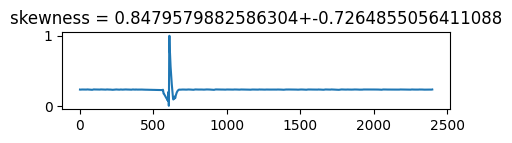

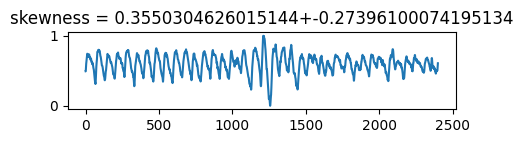

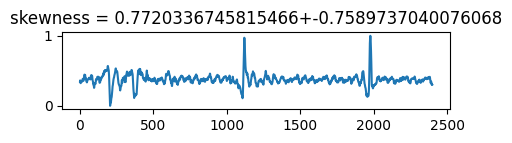

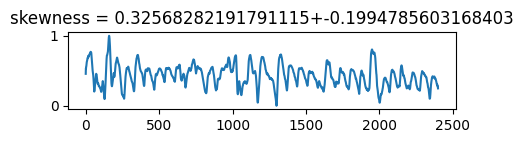

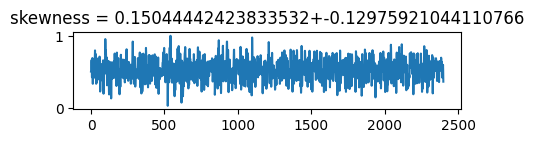

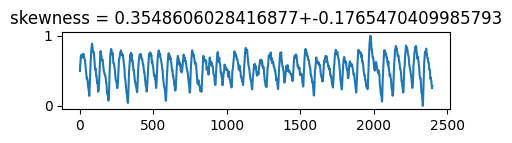

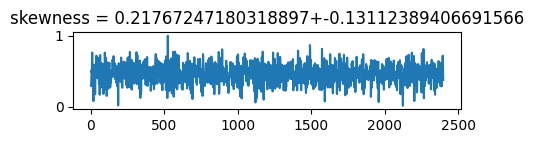

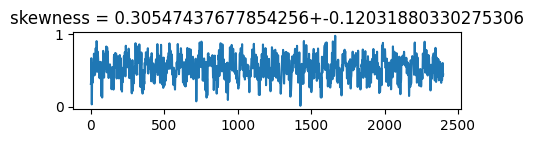

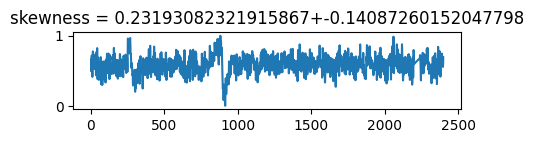

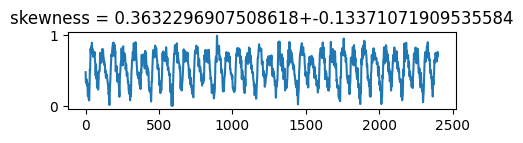

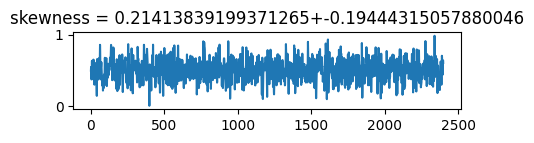

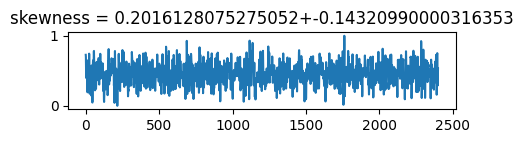

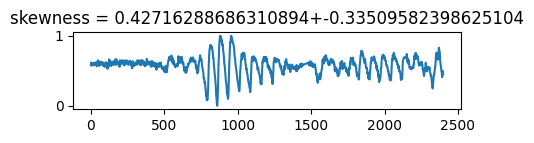

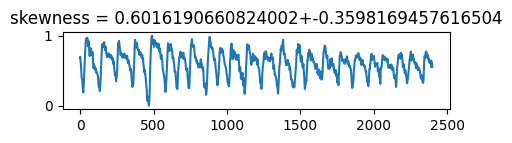

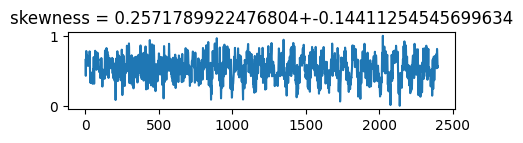

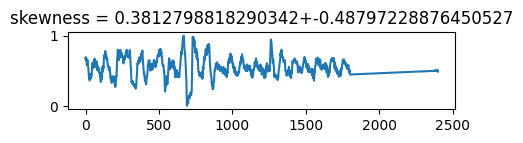

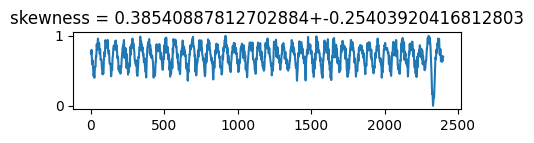

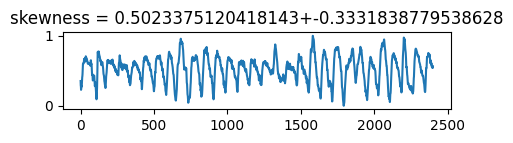

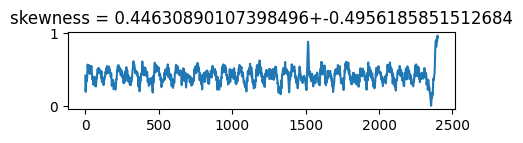

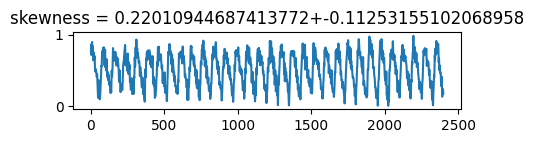

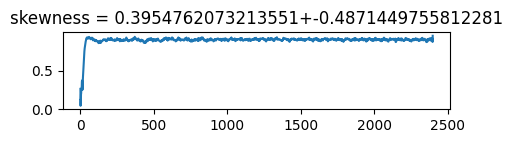

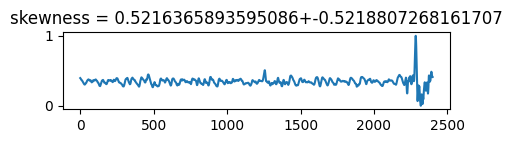

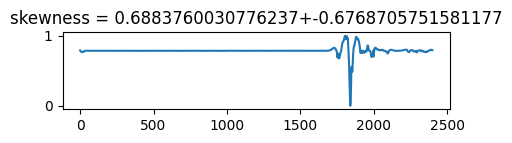

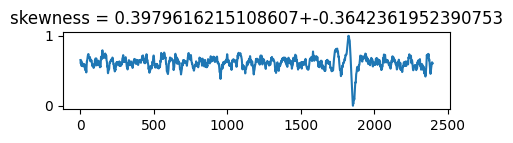

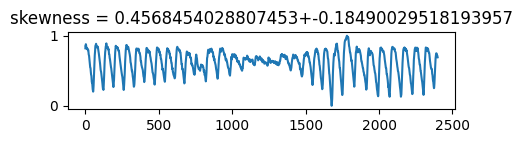

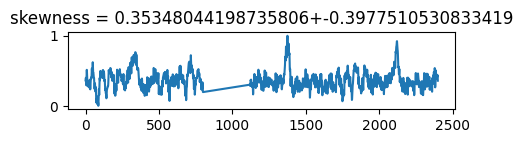

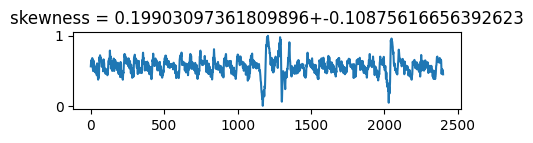

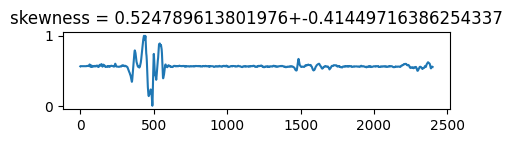

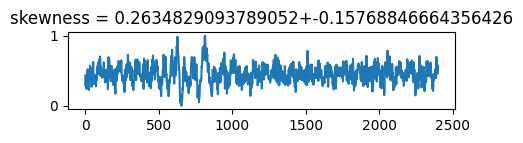

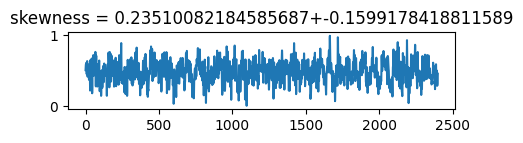

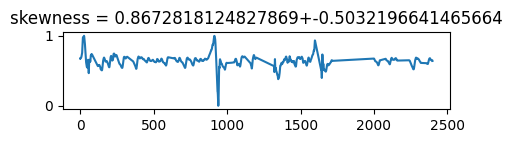

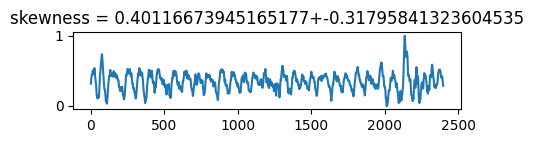

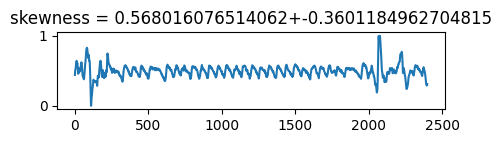

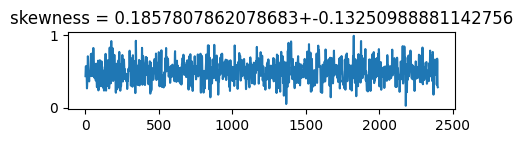

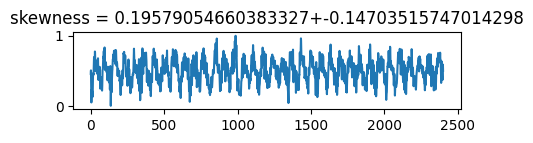

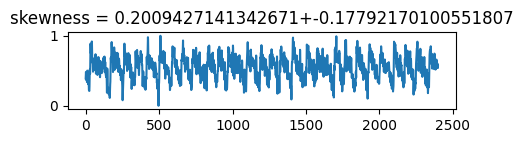

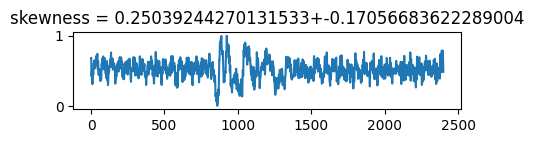

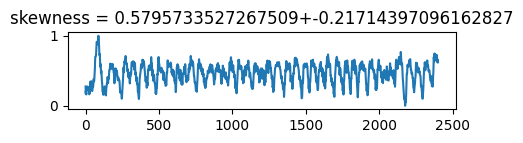

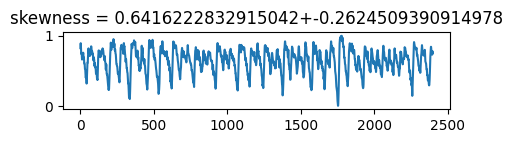

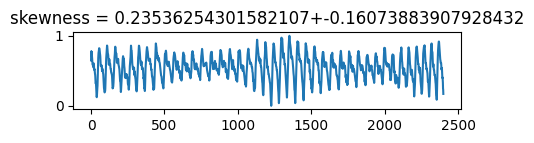

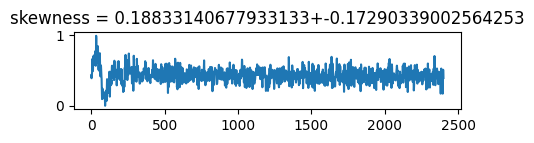

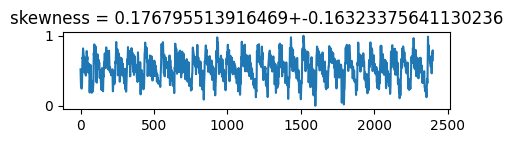

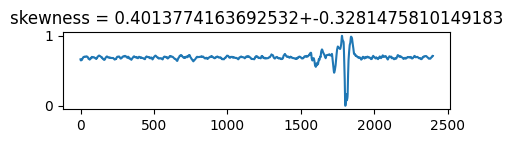

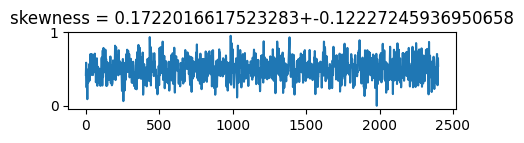

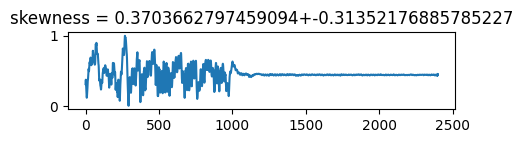

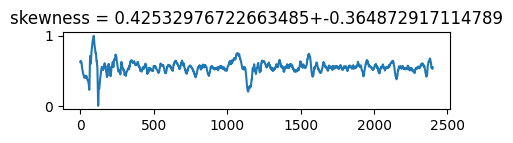

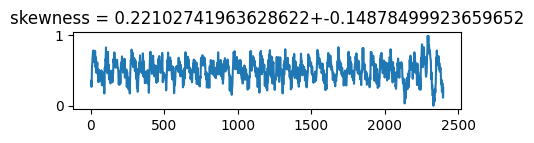

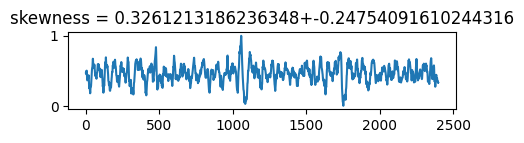

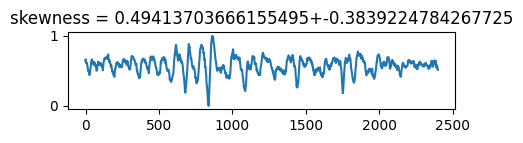

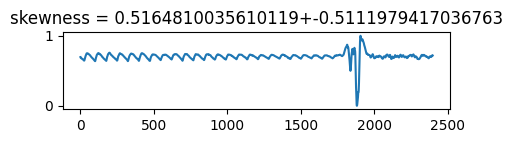

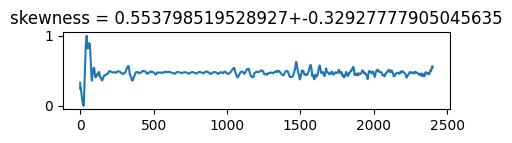

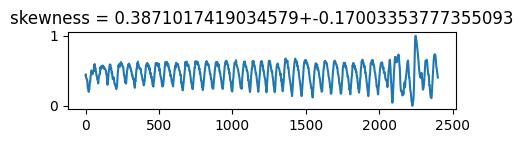

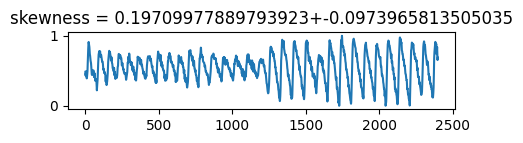

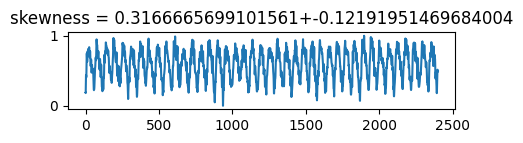

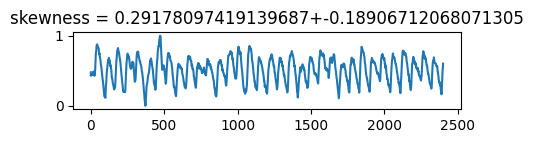

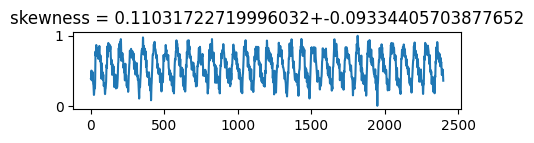

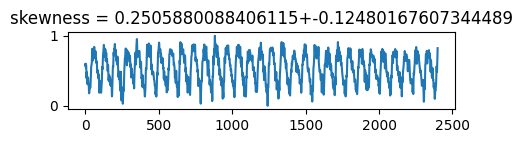

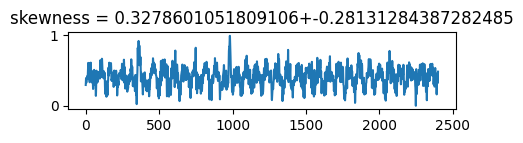

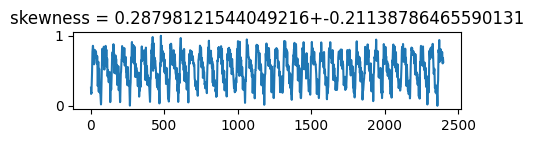

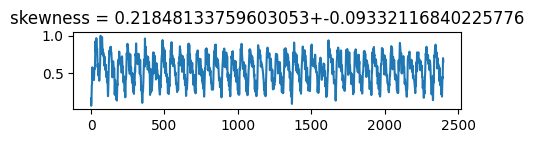

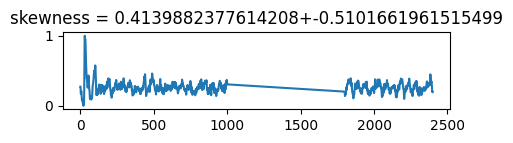

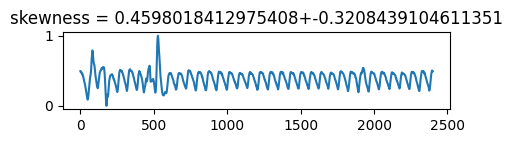

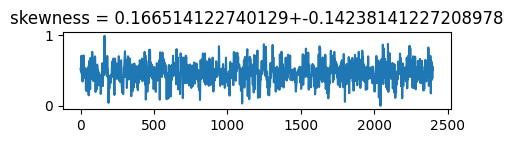

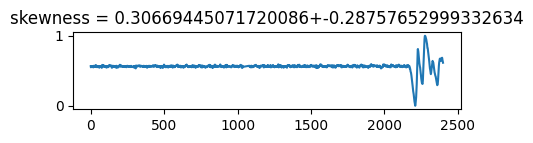

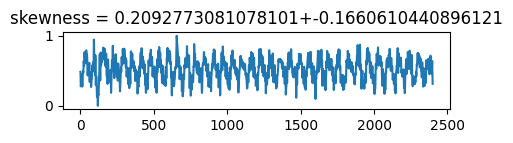

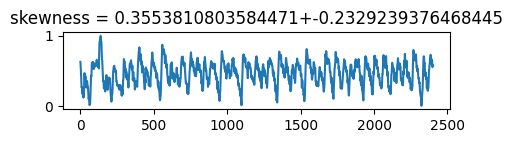

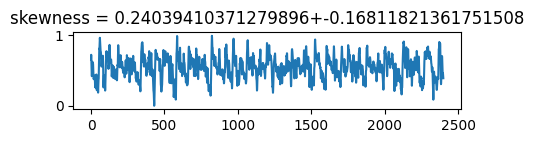

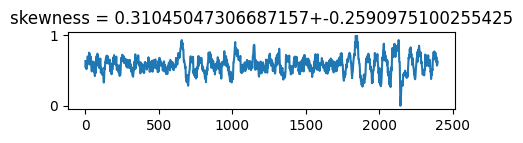

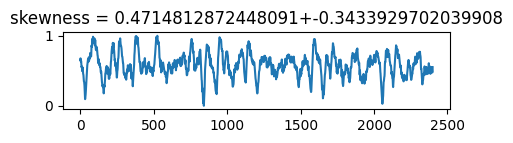

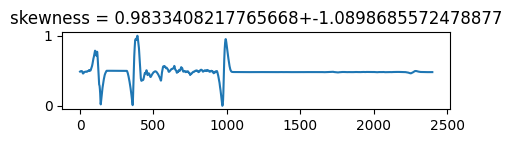

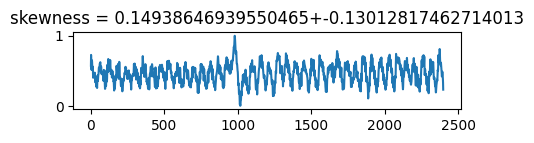

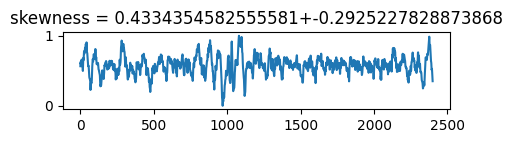

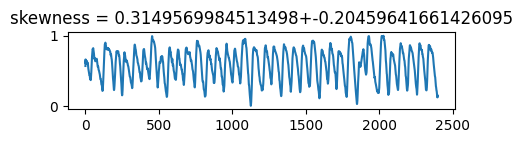

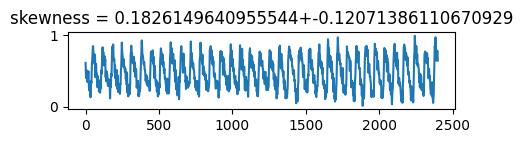

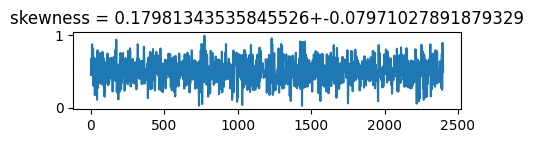

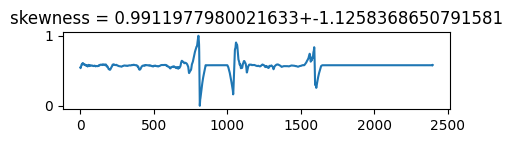

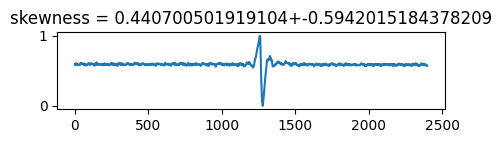

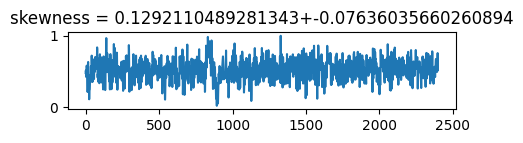

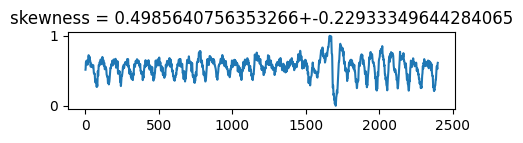

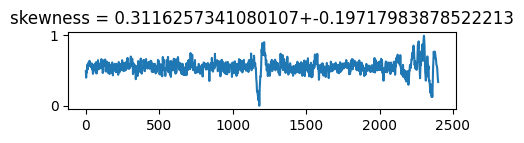

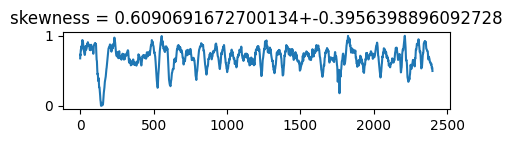

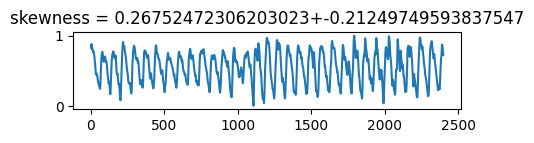

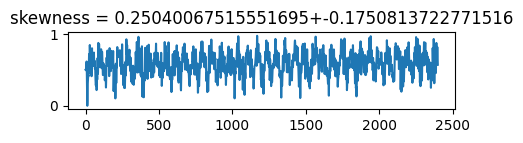

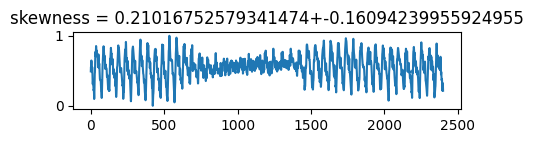

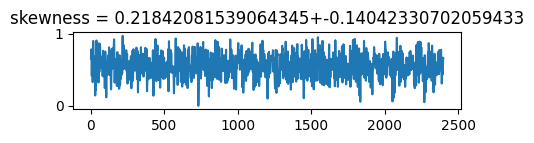

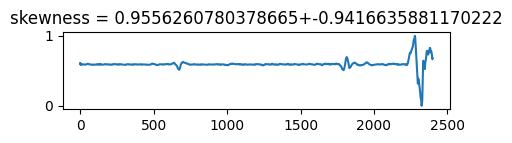

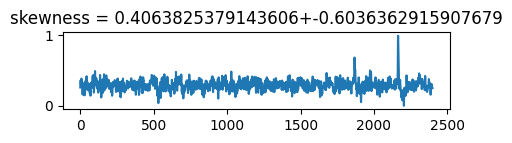

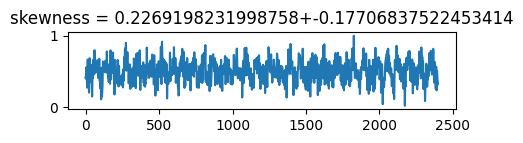

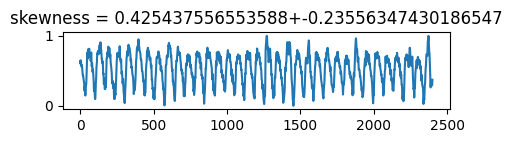

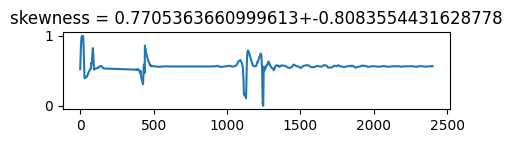

In [45]:
for sig in simbad_badqual[np.random.choice(np.arange(len(simbad_badqual)), replace=False, size=100)]:
    
    skewness = np.abs(calc_skewness(sig))
    if np.mean(skewness) > 0.1:
        plt.figure(figsize=(5, 1))
        plt.plot(sig)
        plt.title(f'skewness = {np.mean(skewness)}+-{np.std(skewness)}')
        plt.show()

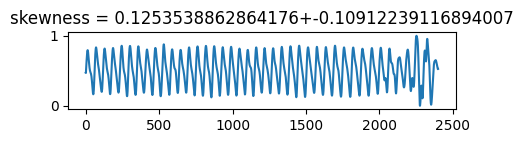

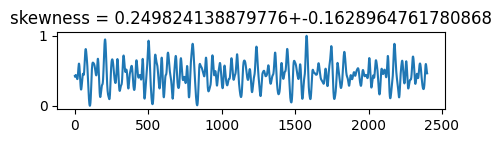

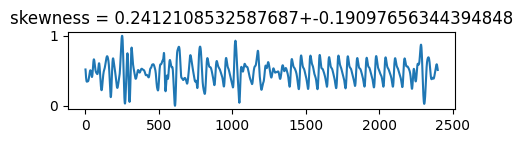

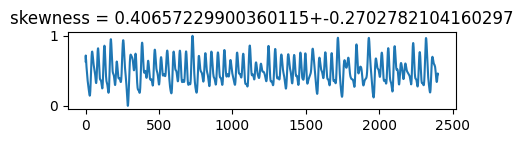

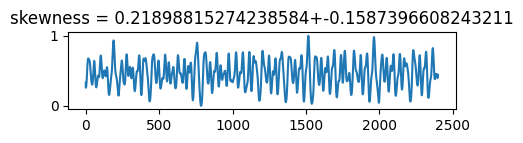

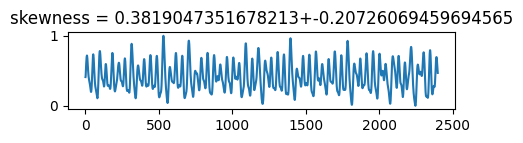

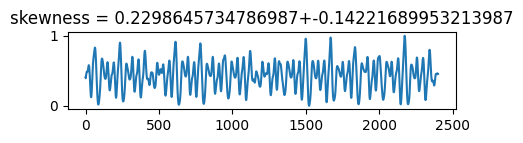

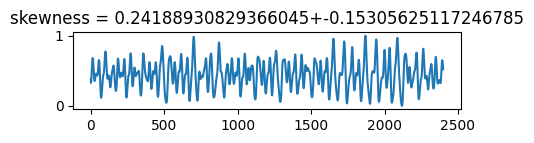

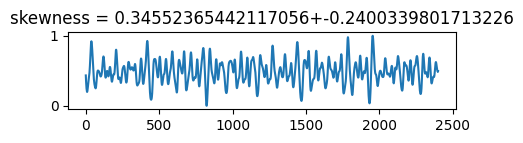

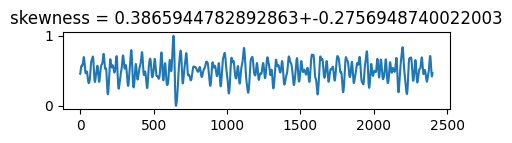

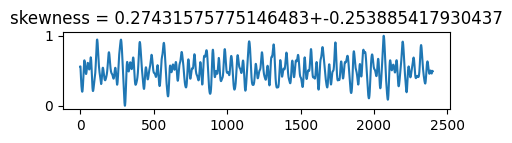

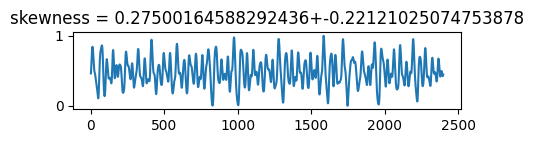

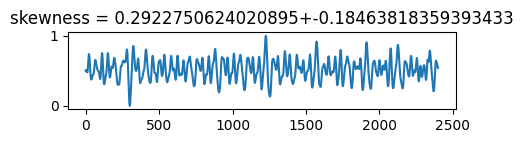

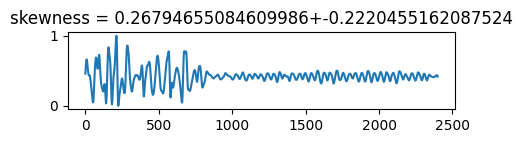

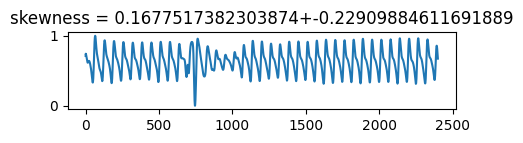

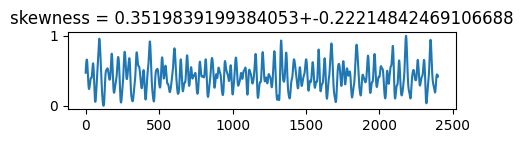

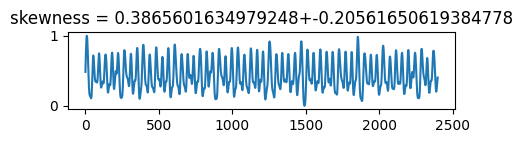

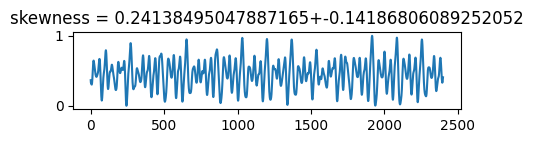

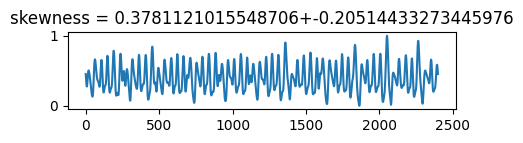

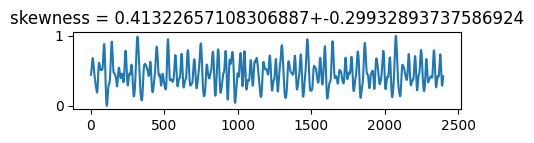

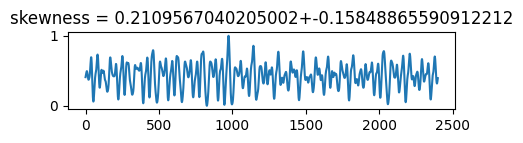

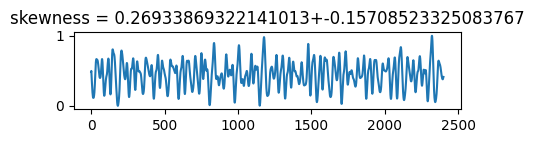

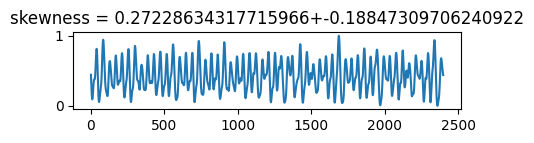

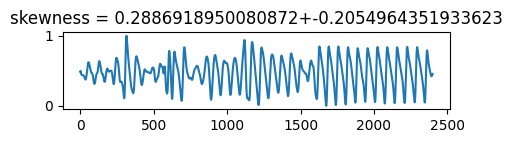

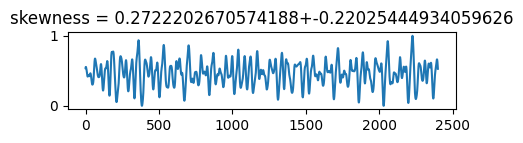

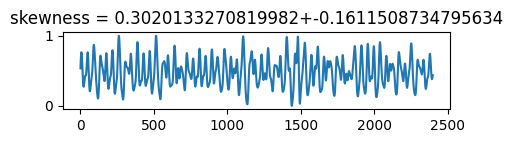

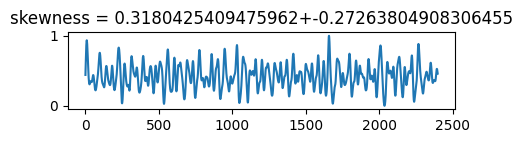

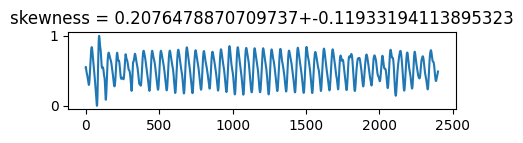

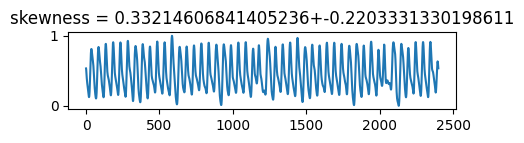

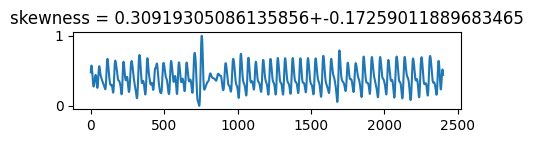

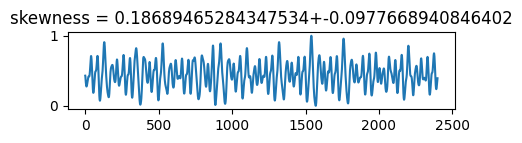

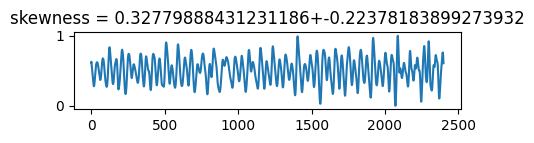

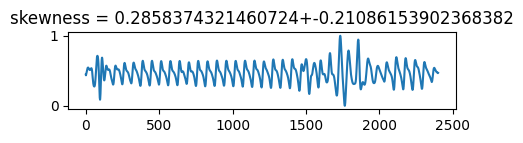

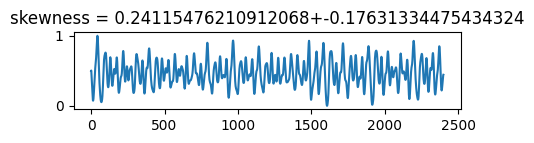

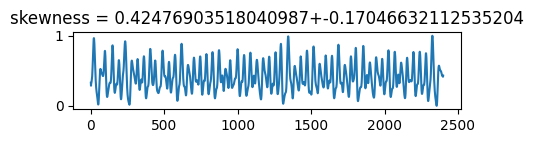

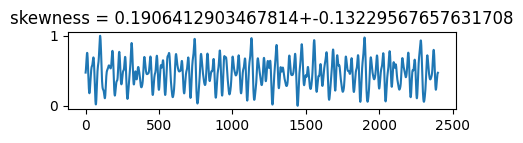

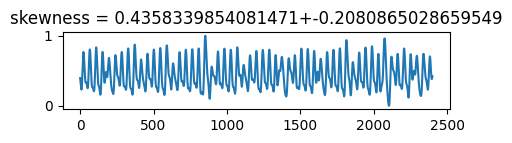

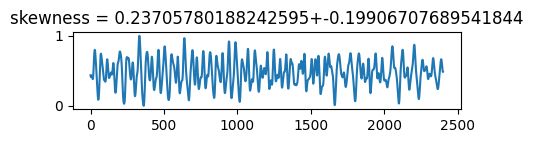

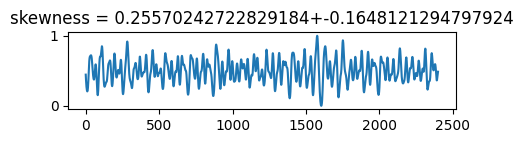

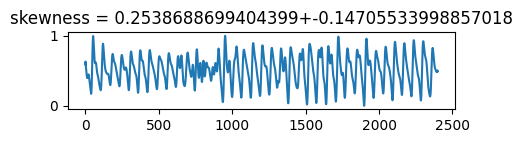

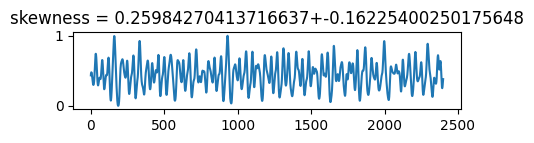

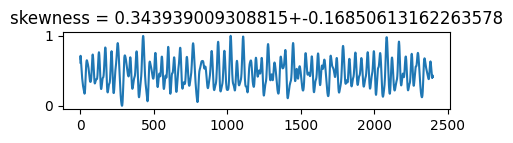

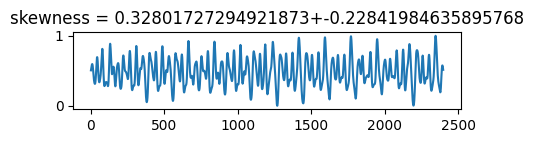

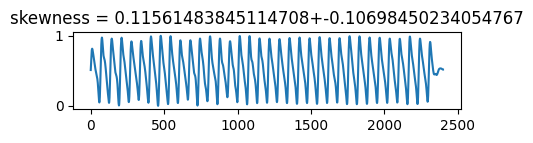

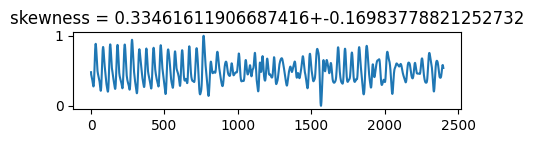

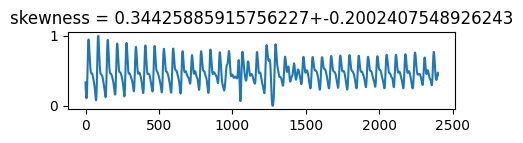

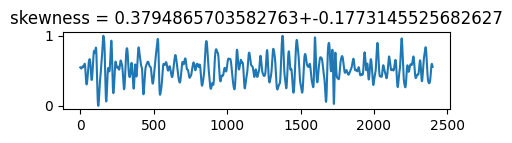

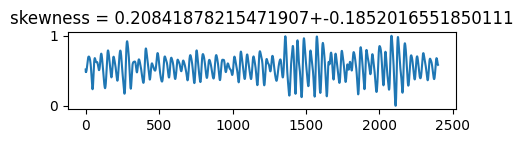

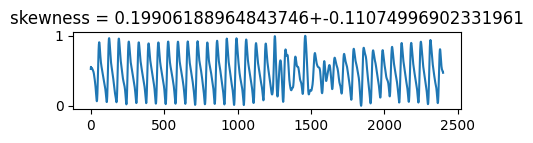

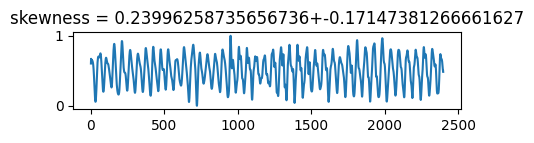

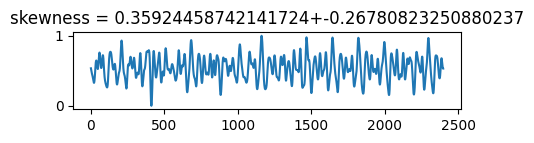

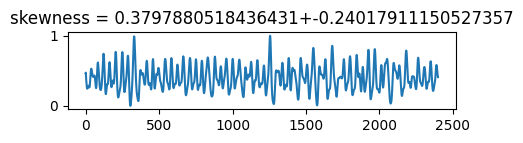

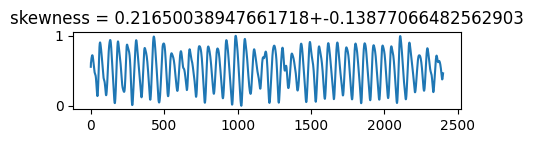

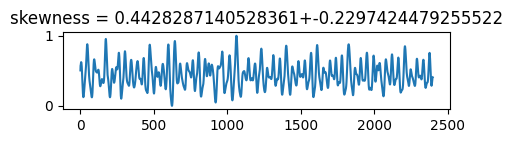

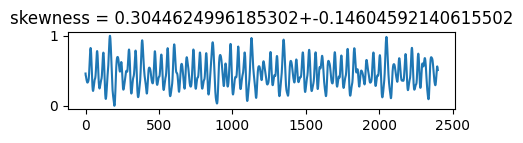

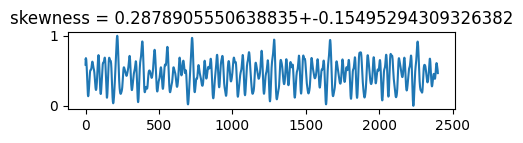

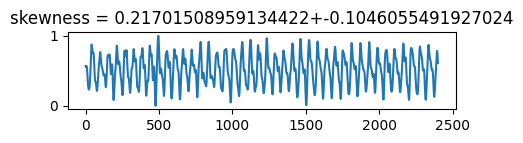

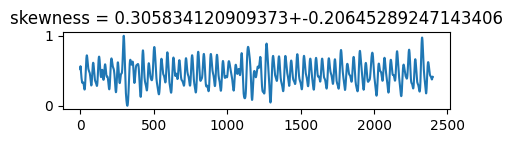

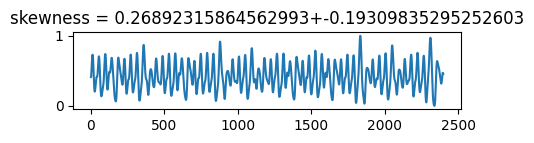

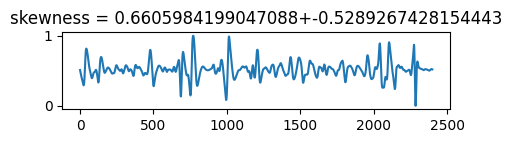

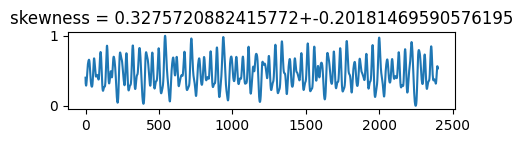

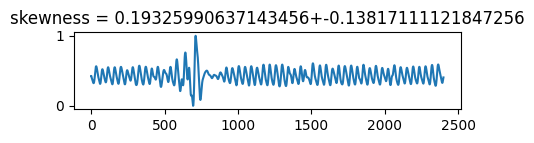

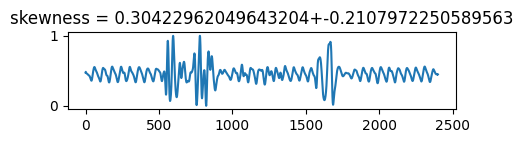

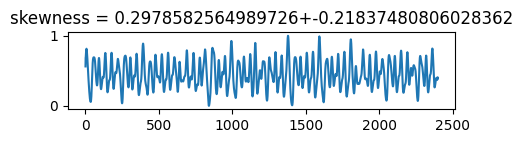

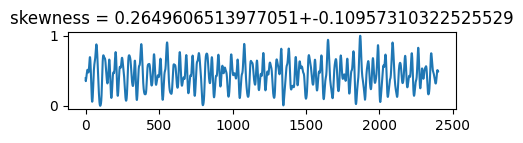

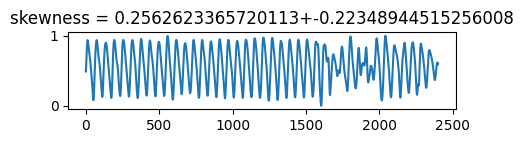

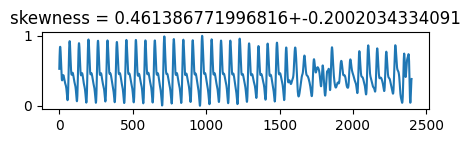

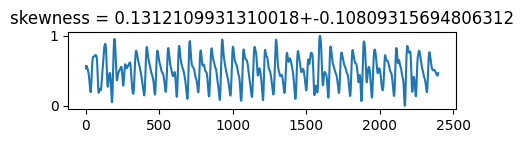

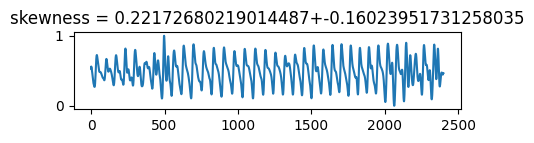

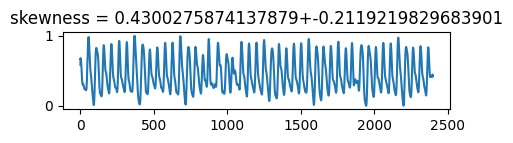

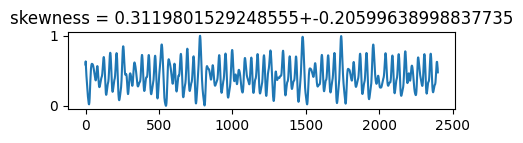

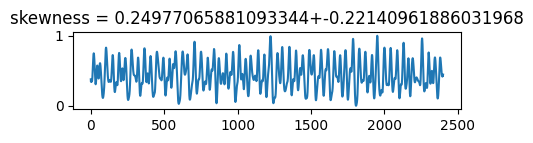

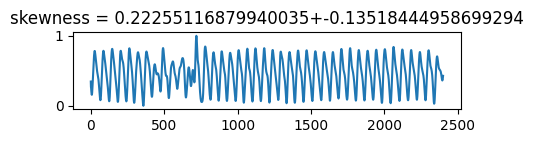

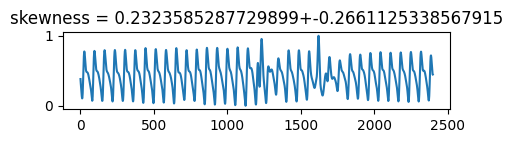

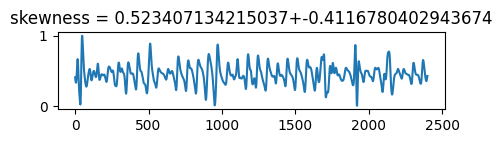

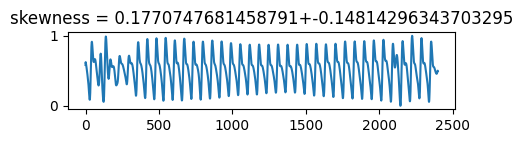

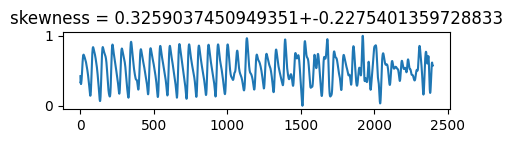

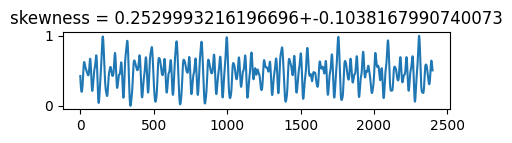

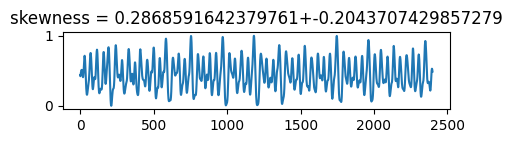

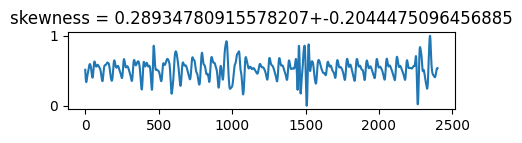

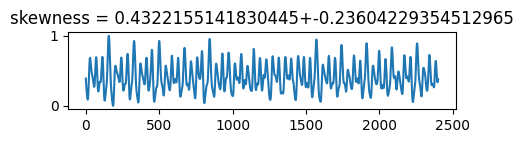

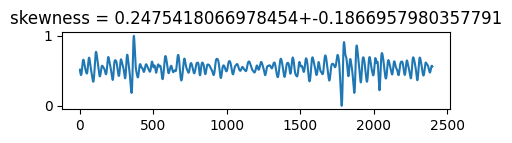

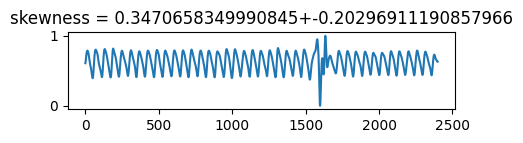

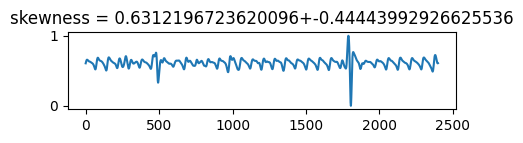

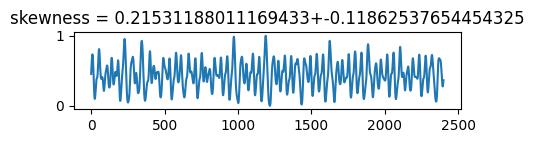

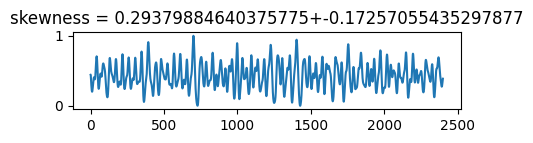

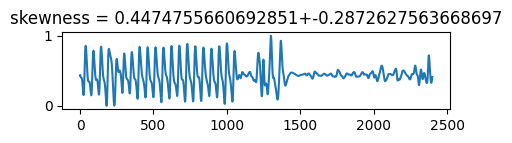

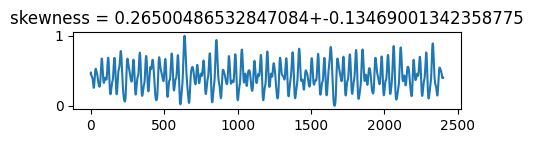

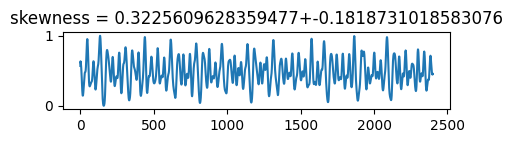

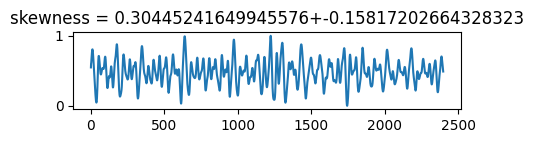

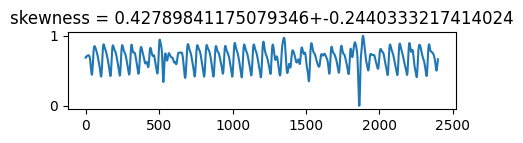

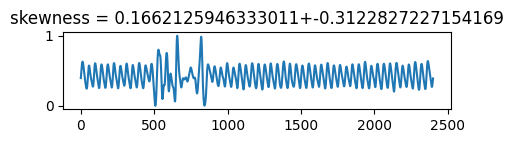

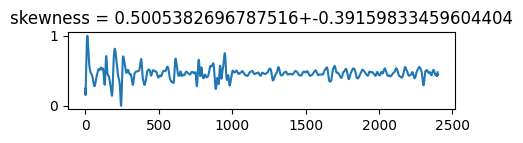

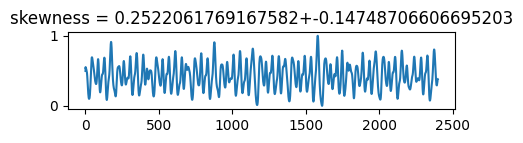

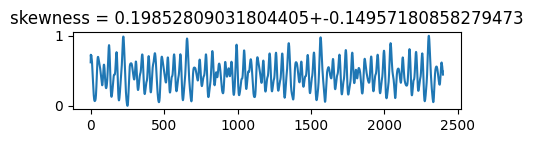

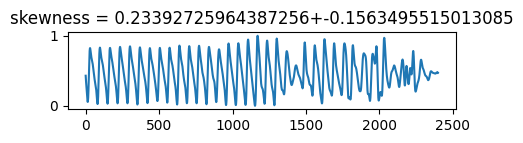

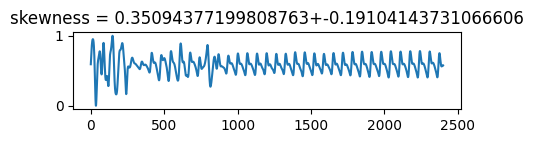

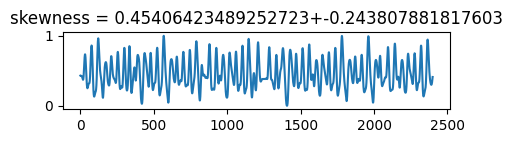

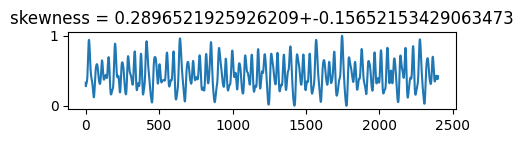

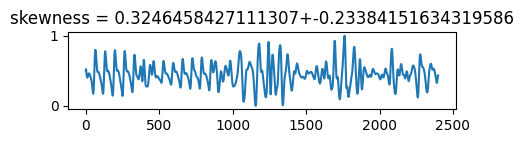

In [44]:
for sig in ucla_badqual[np.random.choice(np.arange(len(simbad_badqual)), replace=False, size=100)]:
    
    skewness = np.abs(calc_skewness(sig))
    if np.mean(skewness) > 0.1:
        plt.figure(figsize=(5, 1))
        plt.plot(sig)
        plt.title(f'skewness = {np.mean(skewness)}+-{np.std(skewness)}')
        plt.show()

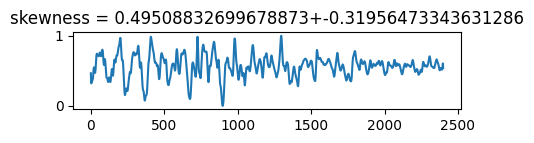

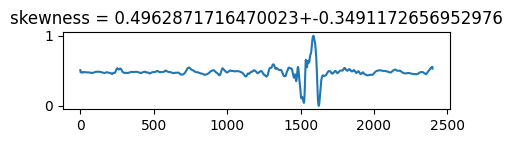

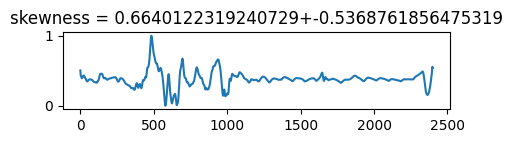

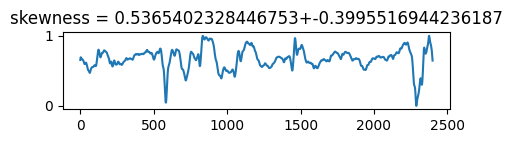

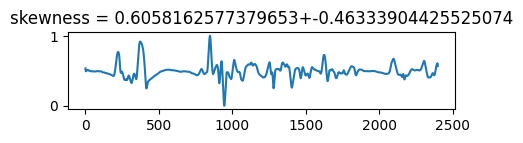

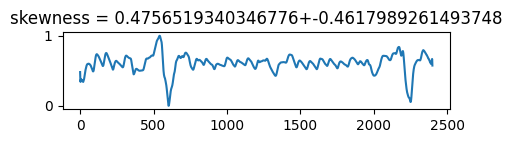

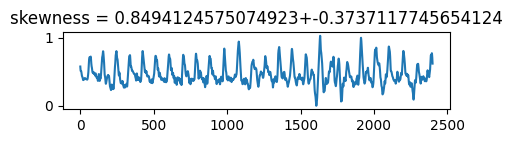

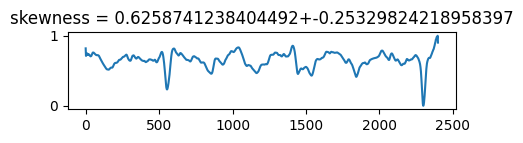

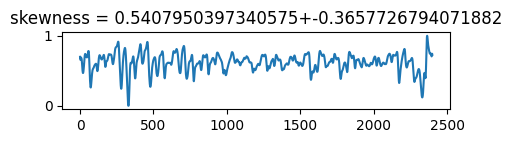

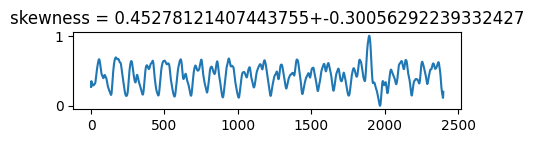

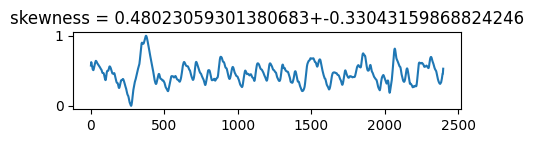

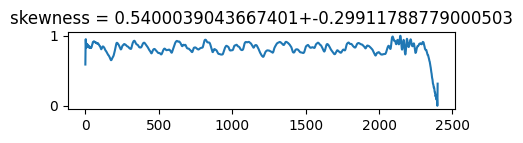

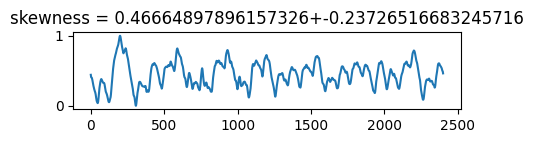

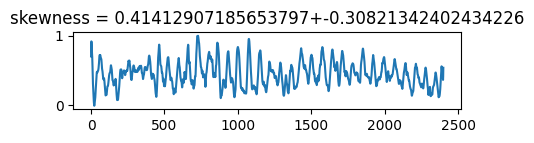

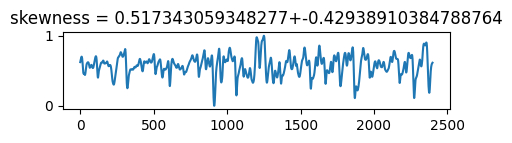

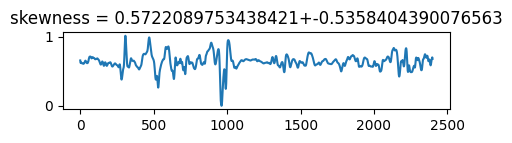

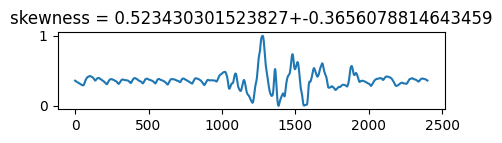

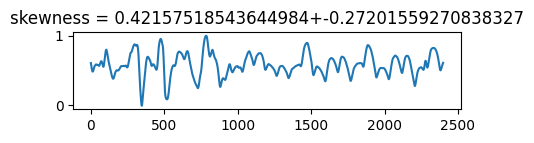

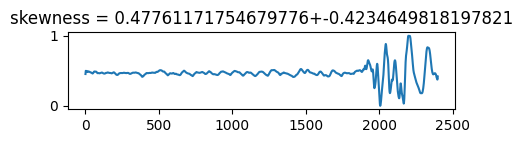

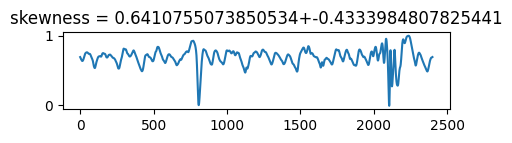

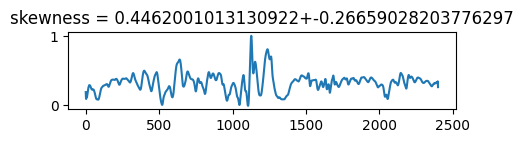

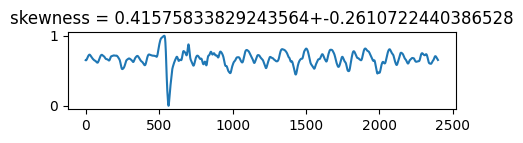

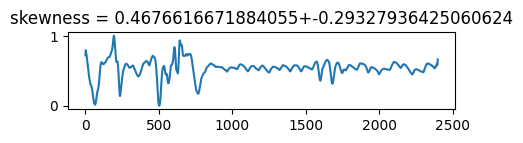

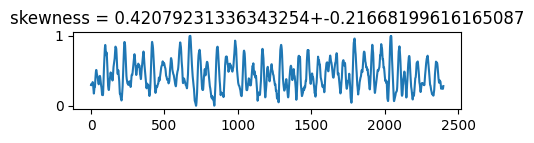

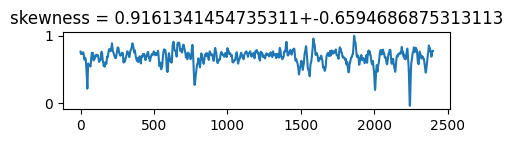

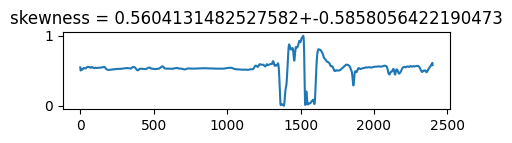

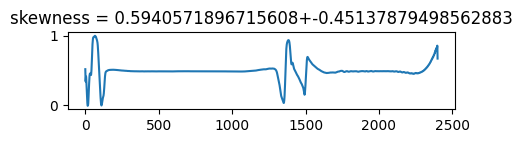

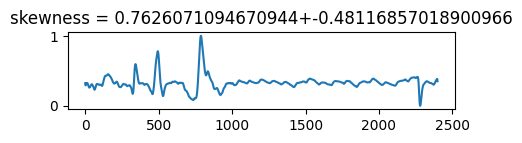

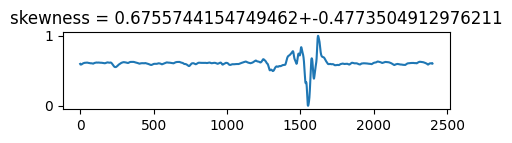

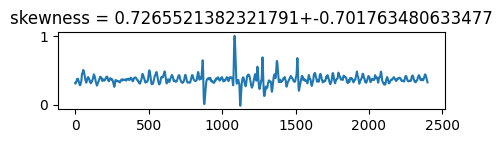

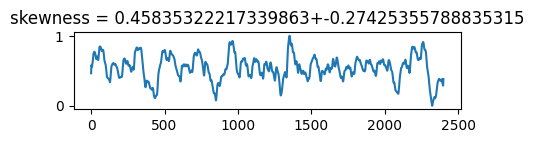

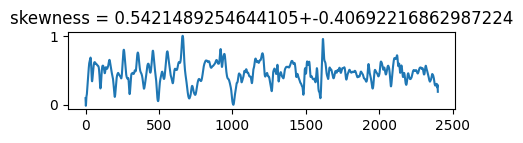

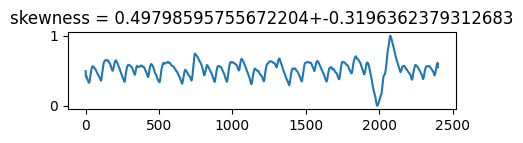

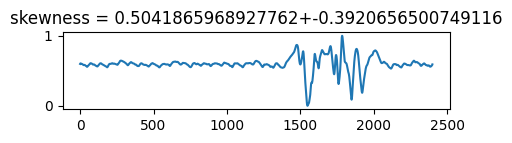

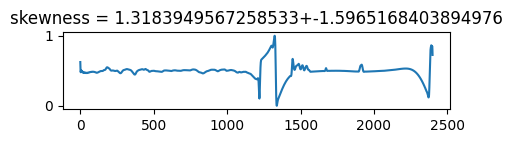

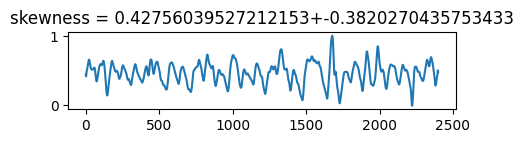

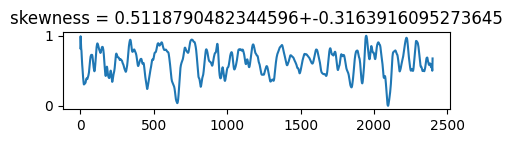

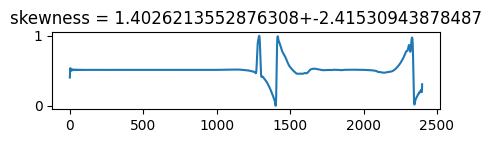

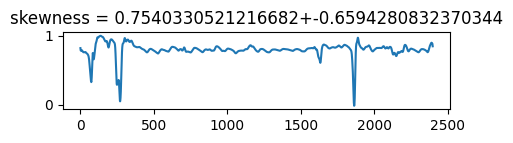

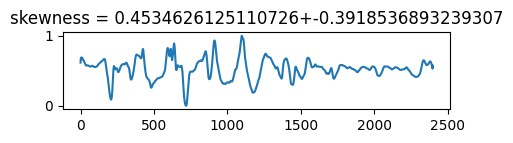

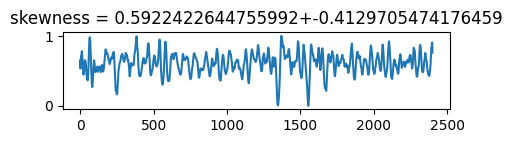

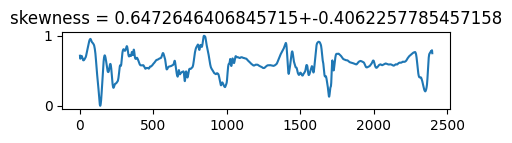

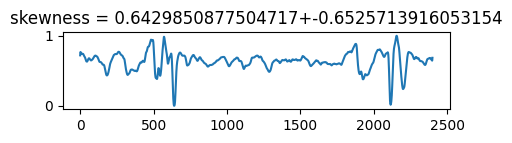

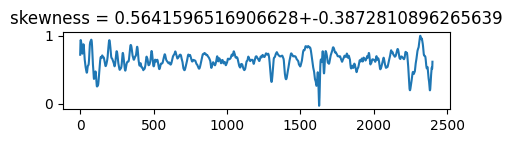

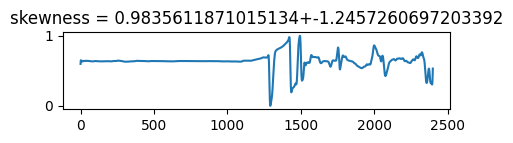

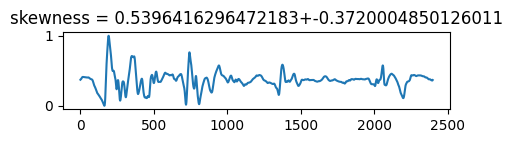

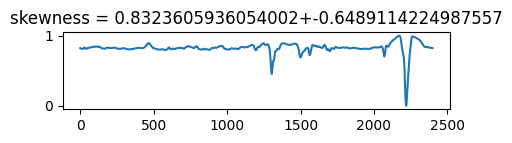

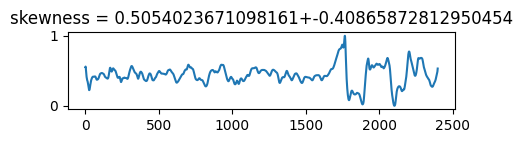

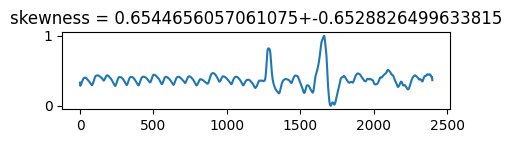

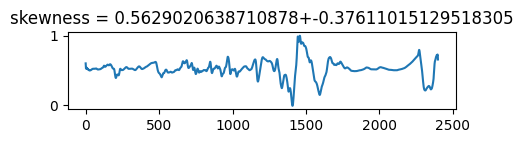

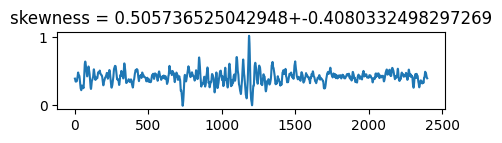

In [26]:
for sig in staford_badqual[np.random.choice(np.arange(len(simbad_badqual)), replace=False, size=100)]:
    
    skewness = np.abs(calc_skewness(sig))
    if np.mean(skewness) > 0.4:
        plt.figure(figsize=(5, 1))
        plt.plot(sig)
        plt.title(f'skewness = {np.mean(skewness)}+-{np.std(skewness)}')
        plt.show()

# Sully model output

In [27]:
simbad_badqual_sully_label = np.load('Sully_out_bad_qual/simbad_badqual_out.npy')
staford_badqual_sully_label = np.load('Sully_out_bad_qual/staford_badqual_out.npy')
ucla_badqual_sully_label = np.load('Sully_out_bad_qual/ucla_badqual_out.npy')

In [39]:
print(np.sum((np.sum(simbad_badqual_sully_label, axis=1) / 2400) > 0.7), simbad_badqual_sully_label.shape)
print(np.sum((np.sum(ucla_badqual_sully_label, axis=1) / 2400) > 0.7), ucla_badqual_sully_label.shape)
print(np.sum((np.sum(staford_badqual_sully_label, axis=1) / 2400) > 0.7), staford_badqual_sully_label.shape)

678 (685, 2400)
51245 (76233, 2400)
13861 (13934, 2400)


In [41]:
simbad_badqual_sully_70_filter = simbad_badqual[(np.sum(simbad_badqual_sully_label, axis=1) / 2400) > 0.7]
ucla_badqual_sully_70_filter = ucla_badqual[(np.sum(ucla_badqual_sully_label, axis=1) / 2400) > 0.7]
stanford_badqual_sully_70_filter = staford_badqual[(np.sum(staford_badqual_sully_label, axis=1) / 2400) > 0.7]

np.save('/labs/hulab/Robust_learning_TESTDATA/data_simbad_badqual_sully_70_filter_2400.npy', simbad_badqual_sully_70_filter)
np.save('/labs/hulab/Robust_learning_TESTDATA/data_ucla_badqual_sully_70_filter_2400.npy', ucla_badqual_sully_70_filter)
np.save('/labs/hulab/Robust_learning_TESTDATA/data_stanford_badqual_sully_70_filter_2400.npy', stanford_badqual_sully_70_filter)

In [43]:
label_simbad_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/label_simband_badquality.npy')
label_staford_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/label_staford_badquality.npy')
label_ucla_badqual = np.load('/labs/hulab/Robust_learning_TESTDATA/label_ucla_badquality.npy')

label_simbad_badqual_sully_70_filter = label_simbad_badqual[(np.sum(simbad_badqual_sully_label, axis=1) / 2400) > 0.7]
label_ucla_badqual_sully_70_filter = label_ucla_badqual[(np.sum(ucla_badqual_sully_label, axis=1) / 2400) > 0.7]
label_stanford_badqual_sully_70_filter = label_staford_badqual[(np.sum(staford_badqual_sully_label, axis=1) / 2400) > 0.7]

np.save('/labs/hulab/Robust_learning_TESTDATA/label_simbad_badqual_sully_70_filter.npy', label_simbad_badqual_sully_70_filter)
np.save('/labs/hulab/Robust_learning_TESTDATA/label_ucla_badqual_sully_70_filter.npy', label_ucla_badqual_sully_70_filter)
np.save('/labs/hulab/Robust_learning_TESTDATA/label_stanford_badqual_sully_70_filter.npy', label_stanford_badqual_sully_70_filter)

In [53]:
np.mean(np.sum(simbad_badqual_sully_label, axis=1) / 2400)

0.98667645

In [54]:
np.mean(np.sum(ucla_badqual_sully_label, axis=1) / 2400)

0.75347304

In [55]:
np.mean(np.sum(staford_badqual_sully_label, axis=1) / 2400)

0.9943247

In [36]:
simbad_badqual_sully_label.shape

(685, 2400)

In [45]:
def get_edges(label):

    """
    Get edges of segmentation labels
    :param label: segmentation label
    :type label: np.ndarray
    :return: edges of segmentation labels
    :rtype: list(int, int)
    """
    label = label.flatten()
    ref = label[1:] - label[:-1]
    base = np.zeros_like(label)
    base[np.where(ref == 1)[0]+1] = 1
    base[np.where(ref == -1)[0]] = 1
    if label[0] == 1:
        base[0] = 1
    if label[-1] == 1:
        base[-1] = 1

    cp_prev = np.concatenate((np.asarray([0]), label[:-1]))
    cp_next = np.concatenate((label[1:], np.asarray([0])))

    cp = cp_prev + cp_next
    cp_base = label - cp

    cp_base[cp_base != 1] = 0
    base[cp_base == 1] = 0

    edges = np.where(base == 1)[0]

    edges = edges.reshape((edges.shape[0] // 2, 2))

    for i in np.where(cp_base == 1)[0]:
        edges = np.concatenate((np.asarray([[i, i]]), edges), axis=0)

    return edges


def plot_on_ppg(ppg, label, title='', color='g', overlay=False, label2=None, color2='y'):
    """
    Plot signal and label on axis
    :param ppg: ppg signals
    :type ppg: np.ndarray
    :param label: segmentation label
    :type label: np.ndarray
    :param ax: axis to be plotted
    :type ax: matplotlib.axes
    :param title: title
    :type title: str
    :param color: matplotlib color for true label
    :type color: str0
    :param overlay:
    :type overlay: bool
    :param label2: segmentation label
    :type label2: np.ndarray
    :param color2: matplotlib color for predicted label
    :type color2: str
    :return: None
    :rtype: None
    """
    plt.plot(ppg)
    plt.margins(x=0, y=0)
    edges = get_edges(label)
    if len(edges) > 0:
        for edge in edges:
            s, e = edge
            if s == e:
                plt.axvline(x=s, color=color, alpha=0.5)
            else:
                plt.axvspan(xmin=s, xmax=e, facecolor=color, alpha=0.5)
    if overlay:
        edges2 = get_edges(label2)
        if len(edges2) > 0:
            for edge in edges2:
                s, e = edge
                if s == e:
                    plt.axvline(x=s, color=color2, alpha=0.5)
                else:
                    plt.axvspan(xmin=s, xmax=e, facecolor=color2, alpha=0.5)
    plt.title(title)

In [50]:
for i in tqdm(range(simbad_badqual.shape[0])):
    plt.figure(figsize=(5, 1))
    plot_on_ppg(simbad_badqual[i], simbad_badqual_sully_label[i], overlay=False)
    plt.savefig(f'Sully_out_bad_qual/simbandbad_viz/{i}.png')
    plt.close('all')

100%|██████████| 685/685 [00:52<00:00, 13.13it/s]


In [42]:
simbad_badqual_sully_label.shape

(685, 2400)

# viz

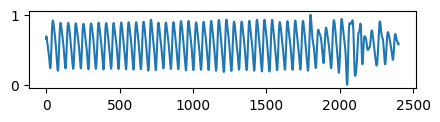

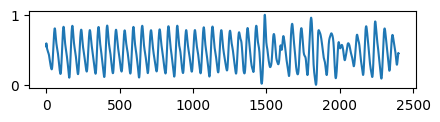

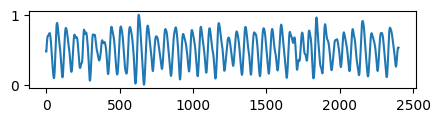

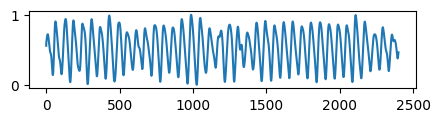

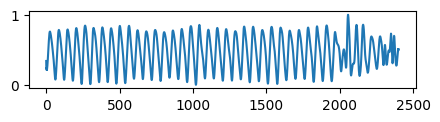

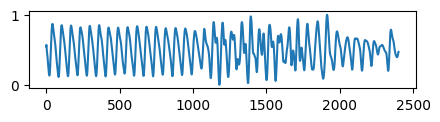

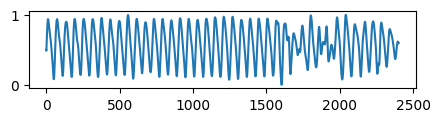

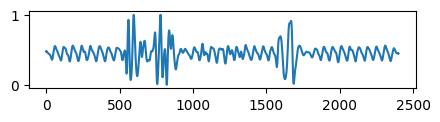

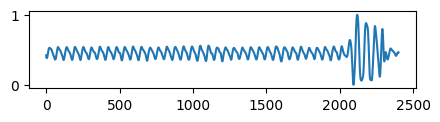

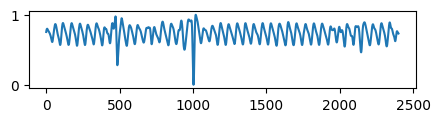

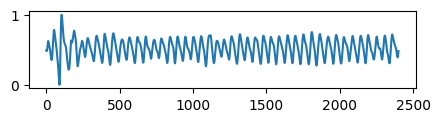

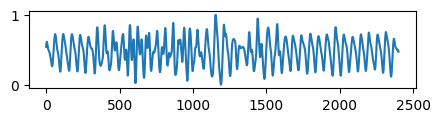

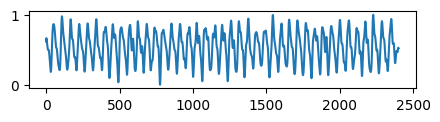

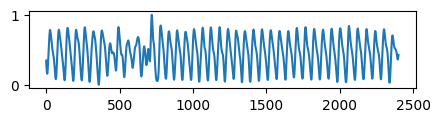

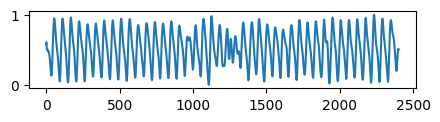

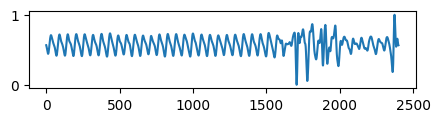

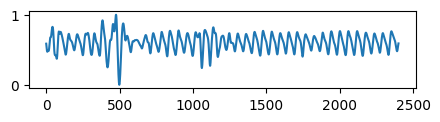

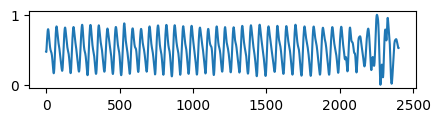

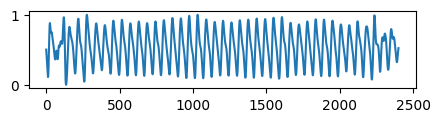

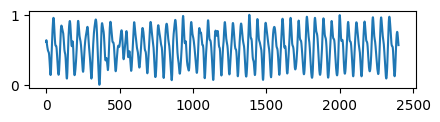

In [13]:
for sig in ucla_badqual[:20]:
    plt.figure(figsize=(5, 1))
    plt.plot(sig)

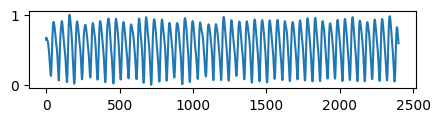

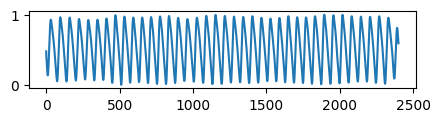

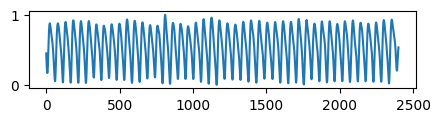

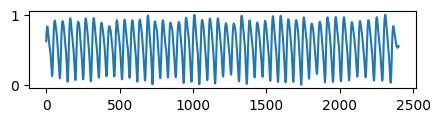

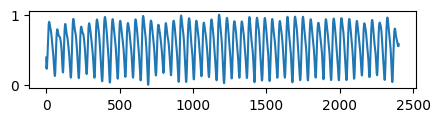

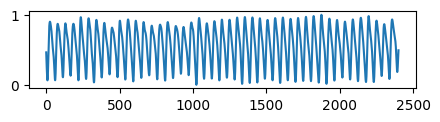

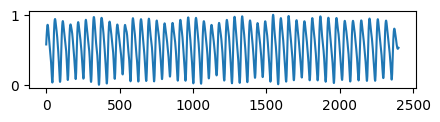

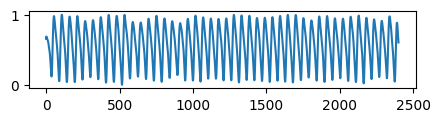

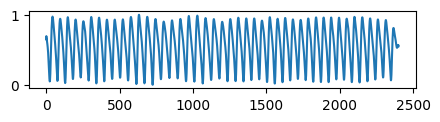

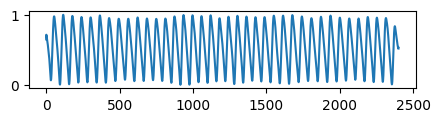

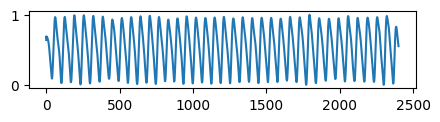

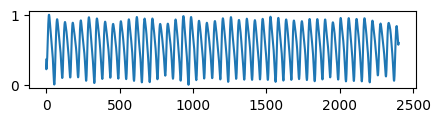

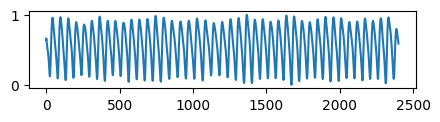

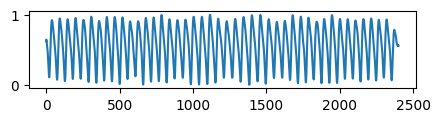

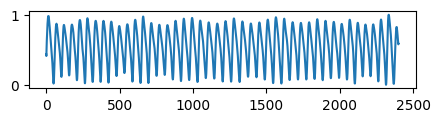

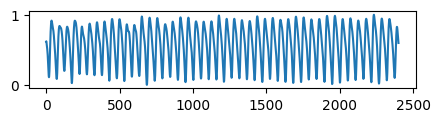

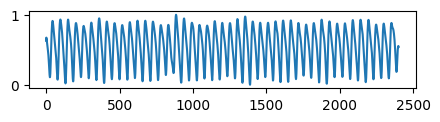

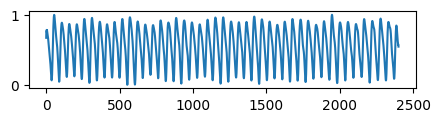

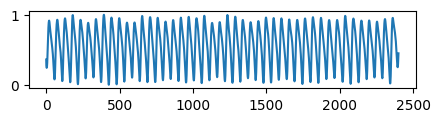

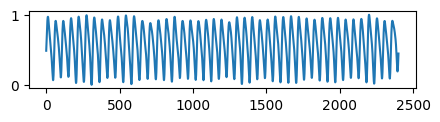

In [12]:
for sig in ucla_goodqual[:20]:
    plt.figure(figsize=(5, 1))
    plt.plot(sig)